In [1]:
# %pip install braindecode mne umap-learn skorch==0.10.0
# %pip install umap-learn[plot] pandas matplotlib datashader bokeh holoviews scikit-image colorcet

# imports
import os
import importlib
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import mne
import torch
from torch import nn
from torch.utils.data import DataLoader
from braindecode.datasets.sleep_physionet import SleepPhysionet
from braindecode.datasets import BaseConcatDataset
from braindecode.datautil.preprocess import preprocess, Preprocessor
from braindecode.preprocessing.windowers import create_windows_from_events
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018
from braindecode import EEGClassifier
from braindecode.datautil.preprocess import zscore
from braindecode.samplers.ssl import RelativePositioningSampler
from braindecode.datasets import (create_from_mne_raw, create_from_mne_epochs)

from sklearn.model_selection import train_test_split
from skorch.helper import predefined_split
from skorch.callbacks import Checkpoint, EarlyStopping, EpochScoring
from skorch.utils import to_tensor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# visualizations

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import learning_curve
from matplotlib import cm
import umap.umap_ as umap
import umap.plot

from umap import UMAP
import plotly.express as px

# ----


# classes
from helper_funcs import HelperFuncs as hf
from ContrastiveNet import *
from RelativePositioningDataset import *
from plot import Plot



# Authors: Hubert Banville <hubert.jbanville@gmail.com>
#
# License: BSD (3-clause)


random_state = 87
n_jobs = 1

/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/braindecode/datautil/preprocess.py:10: UserWarning: datautil.preprocess module is deprecated and is now under preprocessing.preprocess, please use from import braindecode.preprocessing.preprocess
  warn('datautil.preprocess module is deprecated and is now under '



# Self-supervised learning on EEG with relative positioning

This example shows how to train a neural network with self-supervision on sleep
EEG data. We follow the relative positioning approach of [1]_ on the openly
accessible Sleep Physionet dataset [2]_ [3]_.

.. topic:: Self-supervised learning

    Self-supervised learning (SSL) is a learning paradigm that leverages
    unlabelled data to train neural networks. First, neural networks are
    trained on a "pretext task" which uses unlabelled data only. The pretext
    task is designed based on a prior understanding of the data under study
    (e.g., EEG has an underlying autocorrelation struture) and such that the
    processing required to perform well on this pretext task is related to the
    processing required to perform well on another task of interest.
    Once trained, these neural networks can be reused as feature extractors or
    weight initialization in a "downstream task", which is the task that we are
    actually interested in (e.g., sleep staging). The pretext task step can
    help reduce the quantity of labelled data needed to perform well on the
    downstream task and/or improve downstream performance as compared to a
    strictly supervised approach [1]_.

Here, we use relative positioning (RP) as our pretext task, and perform sleep
staging as our downstream task. RP is a simple SSL task, in which a neural
network is trained to predict whether two randomly sampled EEG windows are
close or far apart in time. This method was shown to yield physiologically- and
clinically-relevant features and to boost classification performance in
low-labels data regimes [1]_.
   :depth: 2


## Loading and preprocessing the dataset




### Loading the raw recordings




First, we load a few recordings from the Sleep Physionet dataset. Running
this example with more recordings should yield better representations and
downstream classification performance.




In [2]:
# https://physionet.org/content/sleep-edfx/1.0.0/

# Electrode locations Fpz-Cz, Pz-Oz


dataset = SleepPhysionet(
    subject_ids=[*range(5)],
    recording_ids=[1],
    crop_wake_mins=30,
    load_eeg_only=True,
    sfreq=100
)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
TO resample: 100
Sampling rate before: 100.0
Sampling rate after: 100.0
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
TO resample: 100
Sampling rate before: 100.0
Sampling rate after: 100.0
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
TO resample: 100
Sampling rate before: 100.0
Sampling rate after: 100.0
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
TO resample: 10

### Preprocessing




Next, we preprocess the raw data. We convert the data to microvolts and apply
a lowpass filter. Since the Sleep Physionet data is already sampled at 100 Hz
we don't need to apply resampling.




In [3]:
high_cut_hz = 30

preprocessors = [
    Preprocessor(lambda x: x * 1e6), # convert to microvolts
    Preprocessor('filter', l_freq=None, h_freq=high_cut_hz, n_jobs=n_jobs) # high pass filtering
]

# Transform the data
preprocess(dataset, preprocessors)

/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/braindecode/preprocessing/preprocess.py:52: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter par

### Extracting windows




We extract 30-s windows to be used in both the pretext and downstream tasks.
As RP (and SSL in general) don't require labelled data, the pretext task
could be performed using unlabelled windows extracted with
:func:`braindecode.datautil.windower.create_fixed_length_window`.
Here however, purely for convenience, we directly extract labelled windows so
that we can reuse them in the sleep staging downstream task later.




In [4]:
# change to 5 second windows
window_size_s = 5
sfreq = 100
# window_size_samples = window_size_s * sfreq
window_size_samples = 500

mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}

windows_dataset = create_windows_from_events(
    dataset, trial_start_offset_samples=0, trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples, preload=True, mapping=mapping)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
5017 matching events found
No baseline correction applied
0 projection items activated
Loading data for 5017 events and 500 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
6523 matching events found
No baseline correction applied
0 projection items activated
Loading data for 6523 events and 500 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
6121 matching events found
No baseli

### Preprocessing windows




We also preprocess the windows by applying channel-wise z-score normalization.




In [5]:
preprocess(windows_dataset, [Preprocessor(zscore)])

/home/maligan/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function zscore is deprecated; will be removed in 0.7.0. Use sklearn.preprocessing.scale instead.
  warnings.warn(msg, category=FutureWarning)


### Splitting dataset into train, valid and test sets




We randomly split the recordings by subject into train, validation and
testing sets. We further define a new Dataset class which can receive a pair
of indices and return the corresponding windows. This will be needed when
training and evaluating on the pretext task.




In [6]:
subjects = np.unique(windows_dataset.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)



split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = RelativePositioningDataset(
        [ds for ds in windows_dataset.datasets
         if ds.description['subject'] in values])

### Creating samplers




Next, we need to create samplers. These samplers will be used to randomly
sample pairs of examples to train and validate our model with
self-supervision.

The RP samplers have two main hyperparameters. `tau_pos` and `tau_neg`
control the size of the "positive" and "negative" contexts, respectively.
Pairs of windows that are separated by less than `tau_pos` samples will be
given a label of `1`, while pairs of windows that are separated by more than
`tau_neg` samples will be given a label of `0`. Here, we use the same values
as in [1]_, i.e., `tau_pos`= 1 min and `tau_neg`= 15 mins.

The samplers also control the number of pairs to be sampled (defined with
`n_examples`). This number can be large to help regularize the pretext task
training, for instance 2,000 pairs per recording as in [1]_. Here, we use a
lower number of 250 pairs per recording to reduce training time.




In [7]:
tau_pos, tau_neg = int(sfreq * 60), int(sfreq * 15 * 60)
n_examples_train = 250 * len(splitted['train'].datasets)
n_examples_valid = 250 * len(splitted['valid'].datasets)
n_examples_test = 250 * len(splitted['test'].datasets)

train_sampler = RelativePositioningSampler(
    splitted['train'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_train, same_rec_neg=True, random_state=random_state)
valid_sampler = RelativePositioningSampler(
    splitted['valid'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_valid, same_rec_neg=True,
    random_state=random_state).presample()
test_sampler = RelativePositioningSampler(
    splitted['test'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_test, same_rec_neg=True,
    random_state=random_state).presample()

## Creating the model




We can now create the deep learning model. In this tutorial, we use a
modified version of the sleep staging architecture introduced in [4]_ -
a four-layer convolutional neural network - as our embedder.
We change the dimensionality of the last layer to obtain a 100-dimension
embedding, use 16 convolutional channels instead of 8, and add batch
normalization after both temporal convolution layers.

We further wrap the model into a siamese architecture using the
# :class:`ContrastiveNet` class defined below. This allows us to train the
feature extractor end-to-end.




In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to reproduce results
set_random_seeds(seed=random_state, cuda=device == 'cuda')

# Extract number of channels and time steps from dataset
n_channels, input_size_samples = windows_dataset[0][0].shape
emb_size = sfreq

linear_output = 15

emb = SleepStagerChambon2018(
    n_channels,
    sfreq,
    n_classes=sfreq,
    n_conv_chs=16,
    input_size_s=input_size_samples / sfreq,
    dropout=0,
    apply_batch_norm=True
)

model = ContrastiveNet(emb, linear_output).to(device)

In [26]:
model.emb.fc = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(model.emb._len_last_layer(2, input_size_samples), linear_output)
)

In [27]:
model

ContrastiveNet(
  (emb): SleepStagerChambon2018(
    (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
    (feature_extractor): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(16, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Dropout(p=0.25, inplace=False)
      (1): Linear(in_features=96, out_features=10, bias=True)
    )
  )
  (clf): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [29]:
from torchsummary import summary

summary(model.emb, (1,2,500), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 1, 500]               6
            Conv2d-2           [-1, 16, 2, 501]             816
       BatchNorm2d-3           [-1, 16, 2, 501]              32
              ReLU-4           [-1, 16, 2, 501]               0
         MaxPool2d-5            [-1, 16, 2, 38]               0
            Conv2d-6            [-1, 16, 2, 39]          12,816
       BatchNorm2d-7            [-1, 16, 2, 39]              32
              ReLU-8            [-1, 16, 2, 39]               0
         MaxPool2d-9             [-1, 16, 2, 3]               0
          Dropout-10                   [-1, 96]               0
           Linear-11                   [-1, 10]             970
Total params: 14,672
Trainable params: 14,672
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## Training




We can now train our network on the pretext task. We use similar
hyperparameters as in [1]_, but reduce the number of epochs and increase the
learning rate to account for the smaller setting of this example.




In [36]:
lr = 5e-3
batch_size = 512
n_epochs = 5
num_workers = 0 if n_jobs <= 1 else n_jobs

cp = Checkpoint(dirname='', f_criterion=None, f_optimizer=None, f_history=None)
early_stopping = EarlyStopping(patience=10)
train_acc = EpochScoring(
    scoring='accuracy', on_train=True, name='train_acc', lower_is_better=False)
valid_acc = EpochScoring(
    scoring='accuracy', on_train=False, name='valid_acc',
    lower_is_better=False)
callbacks = [
    ('cp', cp),
    ('patience', early_stopping),
    ('train_acc', train_acc),
    ('valid_acc', valid_acc)
]

clf = EEGClassifier(
    model,
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    max_epochs=n_epochs,
    iterator_train__shuffle=False,
    iterator_train__sampler=train_sampler,
    iterator_valid__sampler=valid_sampler,
    iterator_train__num_workers=num_workers,
    iterator_valid__num_workers=num_workers,
    train_split=predefined_split(splitted['valid']),
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device
)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf.fit(splitted['train'], y=None)
clf.load_params(checkpoint=cp)  # Load the model with the lowest valid_loss

os.remove('./params.pt')  # Delete parameters file

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.5307        0.6995       0.5120        0.6857     +  16.1760
      2       0.5347        0.6809       0.5640        0.6758     +  16.4711
      3       0.5573        0.6757       0.5680        0.6774        32.5761
      4       0.5427        0.6786       0.5480        0.6719     +  23.6444
      5       0.5920        0.6636       0.5920        0.6594     +  27.6171


## Visualizing the results




### Inspecting pretext task performance




We plot the loss and pretext task performance for the training and validation
sets.




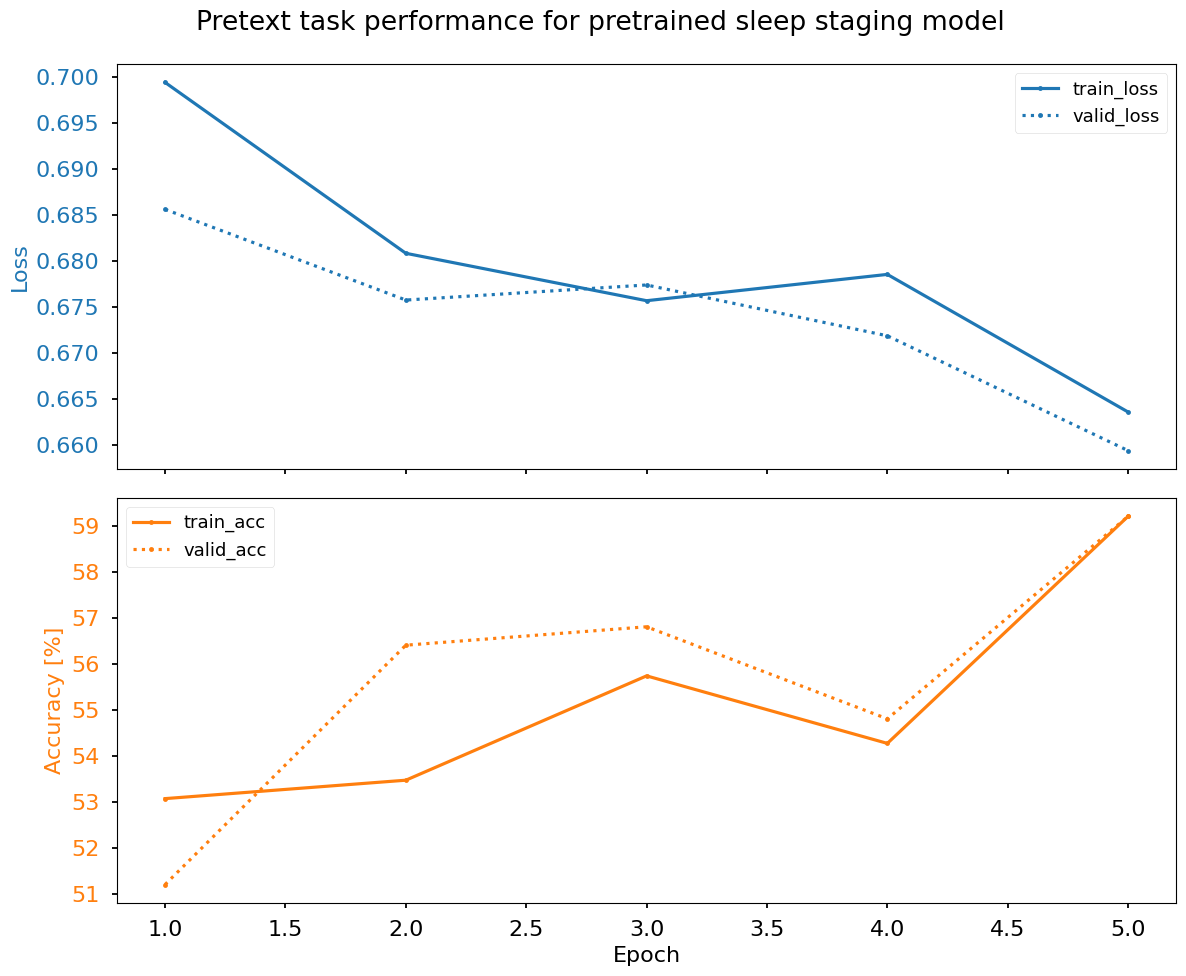

In [48]:
# Extract loss and balanced accuracy values for plotting from history object
df = pd.DataFrame(clf.history.to_list())

df['train_acc'] *= 100
df['valid_acc'] *= 100

ys1 = ['train_loss', 'valid_loss']
ys2 = ['train_acc', 'valid_acc']
styles = ['-', ':']
markers = ['.', '.']


fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for y1, y2, style, marker in zip(ys1, ys2, styles, markers):
    ax[0].plot(df['epoch'], df[y1], ls=style, marker=marker, ms=7,
             c='tab:blue', label=y1)
    lines1, labels1 = ax[0].get_legend_handles_labels()

    ax[0].tick_params(axis='y', labelcolor='tab:blue')
    ax[0].set_ylabel('Loss', color='tab:blue')
    ax[0].legend(lines1, labels1)

for y1, y2, style, marker in zip(ys1, ys2, styles, markers):
    ax[1].grid()
    ax[1].plot(df['epoch'], df[y2], ls=style, marker=marker, ms=7,
             c='tab:orange', label=y2)

    lines2, labels2 = ax[1].get_legend_handles_labels()

    ax[1].tick_params(axis='y', labelcolor='tab:orange')
    ax[1].set_ylabel('Accuracy [%]', color='tab:orange')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(lines2, labels2)


plt.suptitle('Pretext task performance for pretrained sleep staging model')
plt.tight_layout()
plt.style.use('seaborn-talk')
plt.rc('font', size=16)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)

plt.savefig('sample_pretrain.pdf', format='pdf')
plt.show()


In [1]:
# Extract loss and balanced accuracy values for plotting from history object
df = pd.DataFrame(clf.history.to_list())

df['train_acc'] *= 100
df['valid_acc'] *= 100

ys1 = ['train_loss', 'valid_loss']
ys2 = ['train_acc', 'valid_acc']
styles = ['-', ':']
markers = ['.', '.']

plt.style.use('seaborn-talk')

fig, ax1 = plt.subplots(figsize=(16, 6))
ax2 = ax1.twinx()
for y1, y2, style, marker in zip(ys1, ys2, styles, markers):
    ax1.plot(df['epoch'], df[y1], ls=style, marker=marker, ms=7,
             c='tab:blue', label=y1)
    ax2.plot(df['epoch'], df[y2], ls=style, marker=marker, ms=7,
             c='tab:orange', label=y2)

ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylabel('Loss', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_ylabel('Accuracy [%]', color='tab:orange')
ax1.set_xlabel('Epoch')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2)

plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined

In [15]:
from plot import Plot
# init plotting class
p = Plot('test', 'test')

p.plot_acc(clf.history.to_list())

plotting accuracy per epoch...
:: accuracy plot saved


We also display the confusion matrix and classification report for the
pretext task:




In [29]:
# Switch to the test sampler
clf.iterator_valid__sampler = test_sampler
y_pred = clf.forward(splitted['test'], training=False) > 0
y_true = [y for _, _, y in test_sampler]

annotations = ['w', 'N1']

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=annotations))

[[80 49]
 [45 76]]
              precision    recall  f1-score   support

           w       0.64      0.62      0.63       129
          N1       0.61      0.63      0.62       121

    accuracy                           0.62       250
   macro avg       0.62      0.62      0.62       250
weighted avg       0.62      0.62      0.62       250



In [40]:
import seaborn as sns
# from sklearn.metrics import plot_confusion_matrix

# plot_confusion_matrix(clf, y_true, y_pred, labels=annotations)
plt.plot(X, confusion_matrix(y_true, y_pred, labels=annotations))
# sns.heatmap(conf_matrix, annot=True, fmt='g', linewidths=2)
plt.show()

ValueError: At least one label specified must be in y_true

### Save model

In [117]:
import os

### Save model
model_name = f'models/pretrained/sleep_staging_{window_size_s}s_windows_{len(subjects)}_subjects_cpu_{n_epochs}_epochs.model'
torch.save(model, model_name)

print(f'Model trained ~ {os.path.dirname(os.path.abspath("./"))}/{model_name}')

Model trained ~ /home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/models/pretrained/sleep_staging_5s_windows_10_subjects_cpu_5_epochs.model


### Load model

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to reproduce results
set_random_seeds(seed=random_state, cuda=device == 'cuda')

n_channels, input_size_samples = 2, 500
emb_size = 160
sfreq=160

emb = SleepStagerChambon2018(
    n_channels=n_channels,
    sfreq=sfreq,
    n_classes=emb_size,
    n_conv_chs=16,
    input_size_s=input_size_samples / sfreq,
    dropout=0,
    apply_batch_norm=True
)


class ContrastiveNet(nn.Module):
    """Contrastive module with linear layer on top of siamese embedder.

    Parameters
    ----------
    emb : nn.Module
        Embedder architecture.
    emb_size : int
        Output size of the embedder.
    dropout : float
        Dropout rate applied to the linear layer of the contrastive module.
    """
    def __init__(self, emb, emb_size, dropout=0.5):
        super().__init__()
        self.emb = emb
        self.clf = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(emb_size, 1)
        )

    def forward(self, x):
        x1, x2 = x
        z1, z2 = self.emb(x1), self.emb(x2)
        return self.clf(torch.abs(z1 - z2)).flatten()

In [8]:
model = torch.load("models/pretrained/2021_12_16__10_23_49_sleep_staging_5s_windows_83_subjects_cpu_15_epochs_100hz.model")

In [9]:
model

ContrastiveNet(
  (emb): SleepStagerChambon2018(
    (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
    (feature_extractor): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(16, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Dropout(p=0, inplace=False)
      (1): Linear(in_features=96, out_features=100, bias=True)
    )
  )
  (clf): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Testing fine-tuning on model

In [ ]:
import copy

m = copy.deepcopy(model)
m = torch.nn.Module()

In [283]:
# init
n_channels = 19

m.emb.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))
m.emb.feature_extractor

In [278]:
hf.compare_models(model, m)

Models match perfectly! :)


# DOWNSTREAM TASK

### Using the learned representation for sleep staging




We can now use the trained convolutional neural network as a feature
extractor. We perform sleep stage classification from the learned feature
representation using a linear logistic regression classifier.




In [14]:
subjects = np.unique(windows_dataset.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)

split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = RelativePositioningDataset(
        [ds for ds in windows_dataset.datasets
         if ds.description['subject'] in values])

In [15]:
tau_pos, tau_neg = int(sfreq * 60), int(sfreq * 15 * 60)
n_examples_train = 250 * len(splitted['train'].datasets)
n_examples_valid = 250 * len(splitted['valid'].datasets)
n_examples_test = 250 * len(splitted['test'].datasets)

train_sampler = RelativePositioningSampler(
    splitted['train'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_train, same_rec_neg=True, random_state=random_state)
valid_sampler = RelativePositioningSampler(
    splitted['valid'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_valid, same_rec_neg=True,
    random_state=random_state).presample()
test_sampler = RelativePositioningSampler(
    splitted['test'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_test, same_rec_neg=True,
    random_state=random_state).presample()

In [16]:
# Extract features with the trained embedder (simplified)

# data = dict()

# for name, split in splitted.items():
#     split.return_pair = False  # Return single windows
#     loader = DataLoader(split, batch_size=batch_size, num_workers=num_workers)
    
#     with torch.no_grad():
#         for batch_x, _, _ in loader:
#             X = batch_x.to(device)
#             feats = model.emb(X).cpu().numpy()

#     data[name] = (np.concatenate(feats), split.get_metadata()['target'].values)

# --------------------------------------------------------

In [10]:
batch_size = 256
num_workers = 1

# Extract features with the trained embedder
data, raw_data = dict(), dict()
for name, split in splitted.items():
    print(name)
    split.return_pair = False  # Return single windows
    loader = DataLoader(split, batch_size=batch_size, num_workers=num_workers)
    with torch.no_grad():
        feats = [model.emb(batch_x.to(device)).cpu().numpy() for batch_x, _, _ in loader]
        # make a copy of the vectors WITHOUT passing them through the pretrained model
        raw_vectors = [batch_x.to(device).cpu().numpy() for batch_x, _, _ in loader]
    data[name] = (np.concatenate(feats), split.get_metadata()['target'].values)
    # concatinate channels and duplicate labels
    raw_data[name] = (np.concatenate(np.concatenate(raw_vectors)), np.tile(splitted[name].get_metadata()['target'].values, 2))


train
valid
test


In [11]:
# Initialize the logistic regression model
log_reg = LogisticRegression(
    penalty='l2', C=1.0, class_weight='balanced', solver='sag',
    multi_class='multinomial', random_state=random_state)
clf_pipe = make_pipeline(StandardScaler(), log_reg)

In [12]:

# combine all vectors (X) and labels (y) from DATA sets
X = np.concatenate([v[0] for k, v in data.items()])
y = np.concatenate([v[1] for k, v in data.items()])

# combine all vectors (X) and labels (y) from RAW_DATA sets
X_raw = np.concatenate([v[0] for k, v in raw_data.items()])
y_raw = np.concatenate([v[1] for k, v in raw_data.items()])

In [13]:
train_sizes, train_scores, test_scores = learning_curve(
    clf_pipe,
    X=X,
    y=y,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    train_sizes = np.linspace(0.001, 1, 10),
    shuffle=True
)

/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The m

### plotting learning curves

In [16]:
len(train_sizes), test_scores.shape

(10, (10, 5))

In [ ]:
# del sys.modules['plot']
from plot import Plot
p = Plot('testing_dataset', 'xi haga')

p.plot_learning_curves(train_sizes, train_sizes, test_scores, test_scores-0.10, 'test')

:: plotting learning curves (sklearn)... 

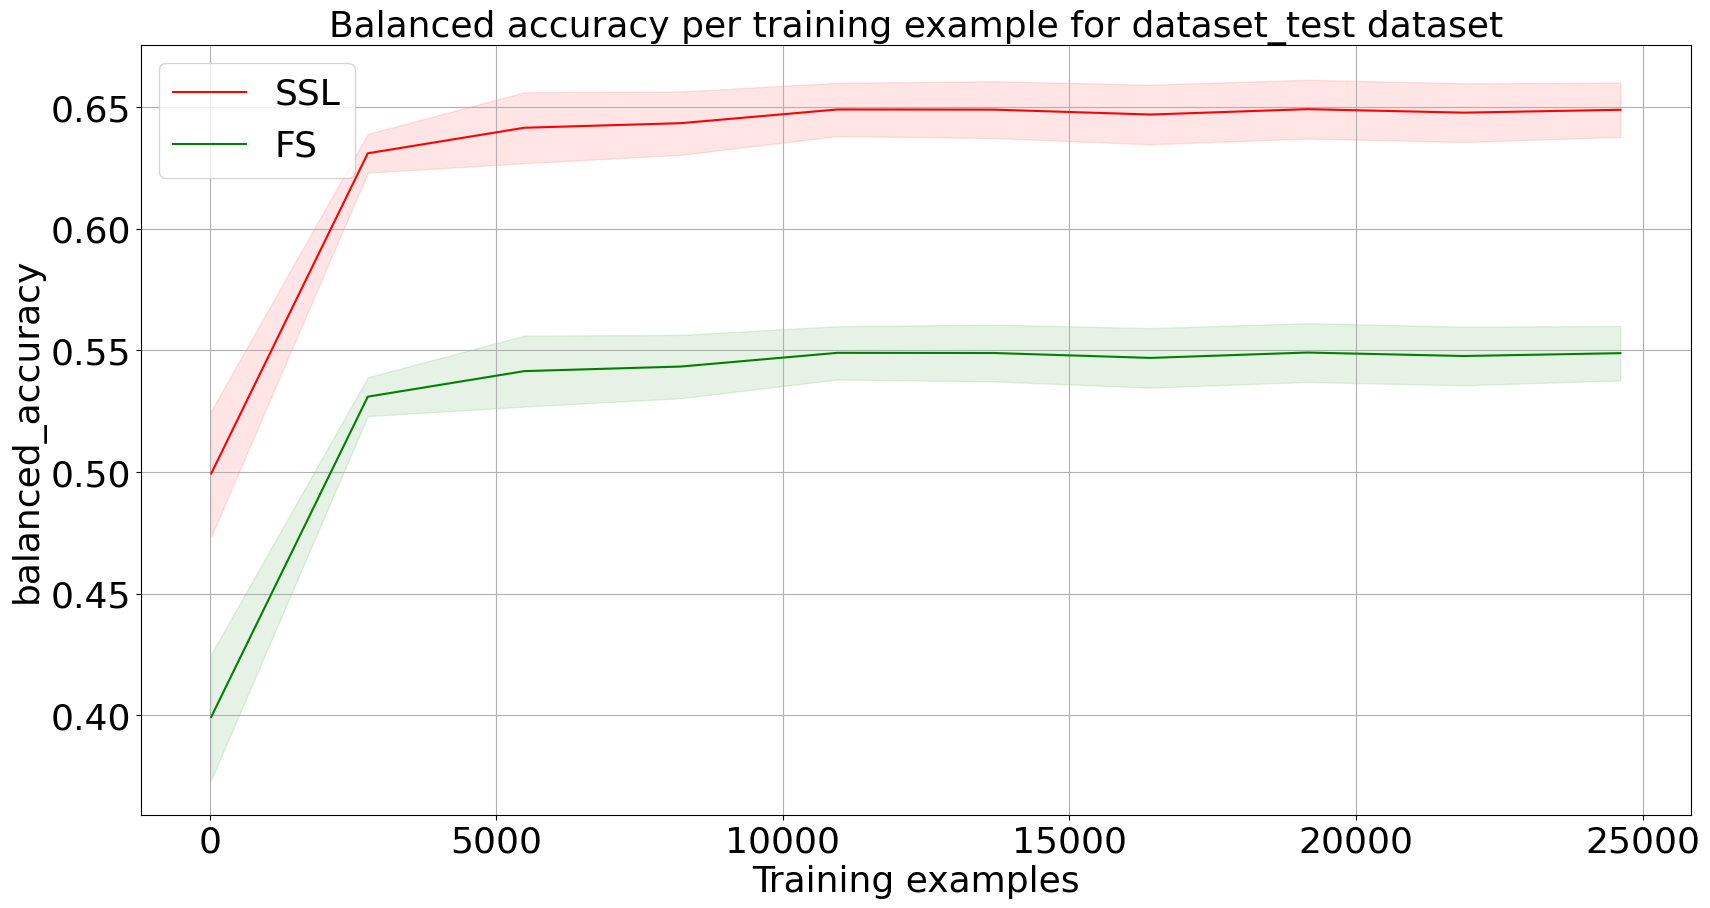

Done


In [18]:
ssl_train_sizes = train_sizes
raw_train_sizes = train_sizes
ssl_test_scores = test_scores
raw_test_scores = test_scores-0.1
scoring = 'balanced_accuracy'
dataset_name = 'dataset_test'

# ----------------------------------------------------------

# create additional features
ssl_test_scores_mean = np.mean(ssl_test_scores, axis=1)
ssl_test_scores_std = np.std(ssl_test_scores, axis=1)
raw_test_scores_mean = np.mean(raw_test_scores, axis=1)
raw_test_scores_std = np.std(raw_test_scores, axis=1)

print(':: plotting learning curves (sklearn)... ', end='')
plt.rc('font', size=26)
plt.rc('xtick', labelsize=26) 
plt.rc('ytick', labelsize=26)
plt.rc('axes', labelsize=26)
_, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.grid()

ax.fill_between(
    ssl_train_sizes,
    ssl_test_scores_mean - ssl_test_scores_std,
    ssl_test_scores_mean + ssl_test_scores_std,
    alpha=0.1,
    color="r",
)
ax.fill_between(
    raw_train_sizes,
    raw_test_scores_mean - raw_test_scores_std,
    raw_test_scores_mean + raw_test_scores_std,
    alpha=0.1,
    color="g",
)

# plt.ylim(0, 1)
ax.set_xlabel("Training examples")
ax.set_ylabel(scoring)

plt.title(f'Balanced accuracy per training example for {dataset_name} dataset', fontsize=26)
plt.plot(ssl_train_sizes, ssl_test_scores_mean, '-', color='r', label='SSL')
plt.plot(raw_train_sizes, raw_test_scores_mean, '-', color='g', label='FS')
plt.legend(loc="best")
plt.show()
# self._plot(plt, 'logit_learning_curves')
print('Done')

In [49]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

_, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.set_title('training examples / score')
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")
ax.grid()
ax.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
ax.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
ax.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
ax.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
ax.legend(loc="best")

plt.show()

NameError: name 'train_scores' is not defined

In [17]:
clf_pipe.fit(*raw_data['train'])

NameError: name 'clf_pipe' is not defined

In [309]:
train_y_pred = clf_pipe.predict(raw_data['train'][0])
valid_y_pred = clf_pipe.predict(raw_data['valid'][0])
test_y_pred = clf_pipe.predict(raw_data['test'][0])

train_bal_acc = balanced_accuracy_score(raw_data['train'][1], train_y_pred)
valid_bal_acc = balanced_accuracy_score(raw_data['valid'][1], valid_y_pred)
test_bal_acc = balanced_accuracy_score(raw_data['test'][1], test_y_pred)

print('Sleep staging performance with logistic regression:')
print(f'Train bal acc: {train_bal_acc:0.4f}')
print(f'Valid bal acc: {valid_bal_acc:0.4f}')
print(f'Test bal acc: {test_bal_acc:0.4f}')

print('Results on test set:')
# confusion matrix
conf_matrix = confusion_matrix(raw_data['test'][1], test_y_pred)
print(conf_matrix)

Sleep staging performance with logistic regression:
Train bal acc: 0.2256
Valid bal acc: 0.2047
Test bal acc: 0.1992
Results on test set:
[[ 2295  3123  1642  2351  1869]
 [ 1192  1593   822  1250   975]
 [ 7229 10156  5092  7381  5878]
 [ 1680  2214  1136  1681  1281]
 [ 2468  3363  1712  2546  2019]]


In [224]:
raw_data['train']

TypeError: tuple indices must be integers or slices, not str

ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [32]:
splitted['train'][0][0]

array([[ 7.02110291e-01,  9.25203145e-01,  3.92259151e-01,
         8.26050758e-01,  5.28593659e-01,  5.34790695e-01,
         2.80712754e-01,  1.84671278e-03,  4.91411537e-01,
         2.24939540e-01,  4.85214502e-01,  4.52258736e-02,
         3.92259151e-01,  1.84671278e-03,  1.25787169e-01,
        -3.38989556e-01,  3.28318290e-02, -2.70822287e-01,
         8.24080110e-02, -1.53078854e-01, -1.34487793e-01,
         5.71972847e-01,  2.43530601e-01,  2.18742520e-01,
         7.00139627e-02,  4.23244268e-01,  1.93954423e-01,
         4.85214502e-01,  3.79865110e-01, -3.69974673e-01,
         1.87757403e-01,  3.92259151e-01,  1.07196100e-01,
         1.69166327e-01,  1.25787169e-01,  4.41835344e-01,
         3.92259151e-01,  3.98456186e-01,  2.93106794e-01,
         5.59578776e-01,  8.32247794e-01,  5.03805578e-01,
         5.65775812e-01,  6.58731163e-01,  1.00576448e+00,
         3.42682987e-01,  3.92259151e-01,  2.06348464e-01,
         3.11697870e-01,  6.27746046e-01,  4.17047262e-0

In [89]:
len(splitted['test'][0][0])
splitted['test'][0][1]

0

In [93]:
len(data['test'][0][0])
data['test'][0]

array([[-2.6709785 ,  0.5585439 ,  1.3509535 , ...,  0.11312826,
         1.6155797 ,  1.6103745 ],
       [-2.9678998 ,  0.36052474,  1.0729659 , ...,  0.4010257 ,
         1.1738971 ,  2.3683844 ],
       [-2.725705  ,  1.0539876 ,  0.4354596 , ...,  0.5039524 ,
         1.6030335 ,  2.2124417 ],
       ...,
       [-2.6759672 ,  0.6877333 ,  0.8677749 , ...,  0.2681794 ,
         1.72128   ,  1.7472546 ],
       [-2.6117291 ,  0.7065406 ,  0.8199125 , ..., -0.0204439 ,
         1.8855969 ,  1.948539  ],
       [-2.635583  ,  0.8194828 ,  0.7120187 , ..., -0.22334257,
         1.845989  ,  1.9323772 ]], dtype=float32)

In [82]:
# fully supervised

log_reg = LogisticRegression(
    penalty='l2', C=1.0, class_weight='balanced', solver='sag',
    multi_class='multinomial', random_state=random_state)

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    log_reg, data['test'][0], data['test'][1], return_times=True
)

/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The m

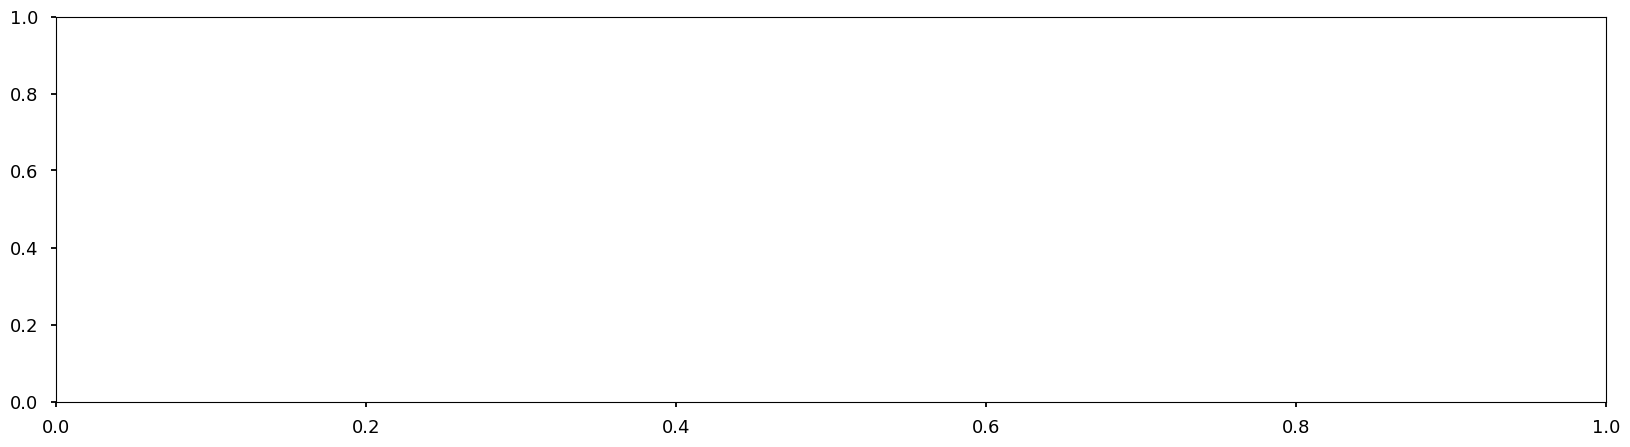

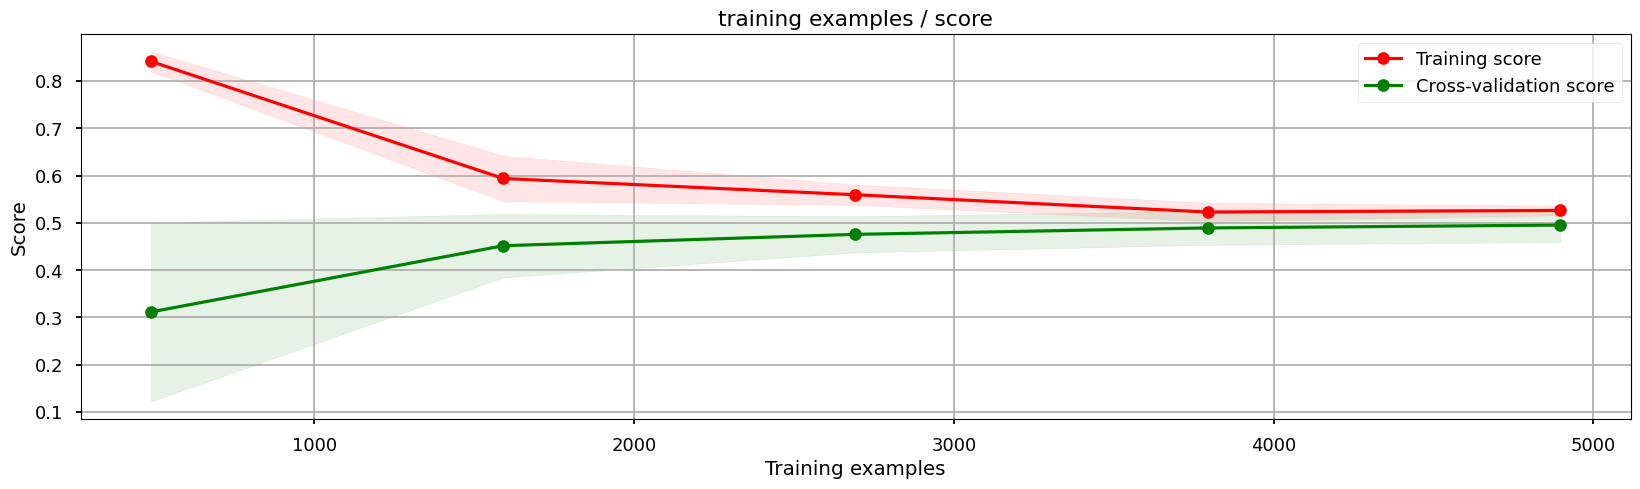

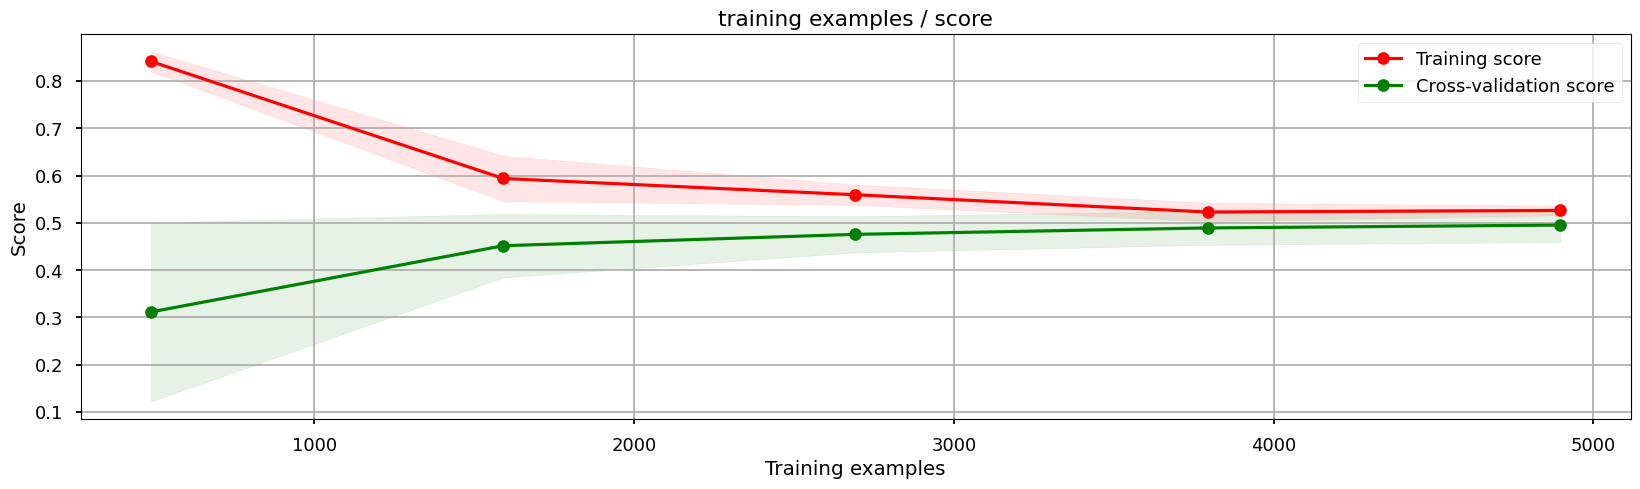

In [86]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

_, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.set_title('training examples / score')
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")
ax.grid()
ax.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
ax.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
ax.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
ax.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
ax.legend(loc="best")

plt.show()

In [36]:
import plot_learning_curve as plc
from sklearn.model_selection import ShuffleSplit
import json

/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The m

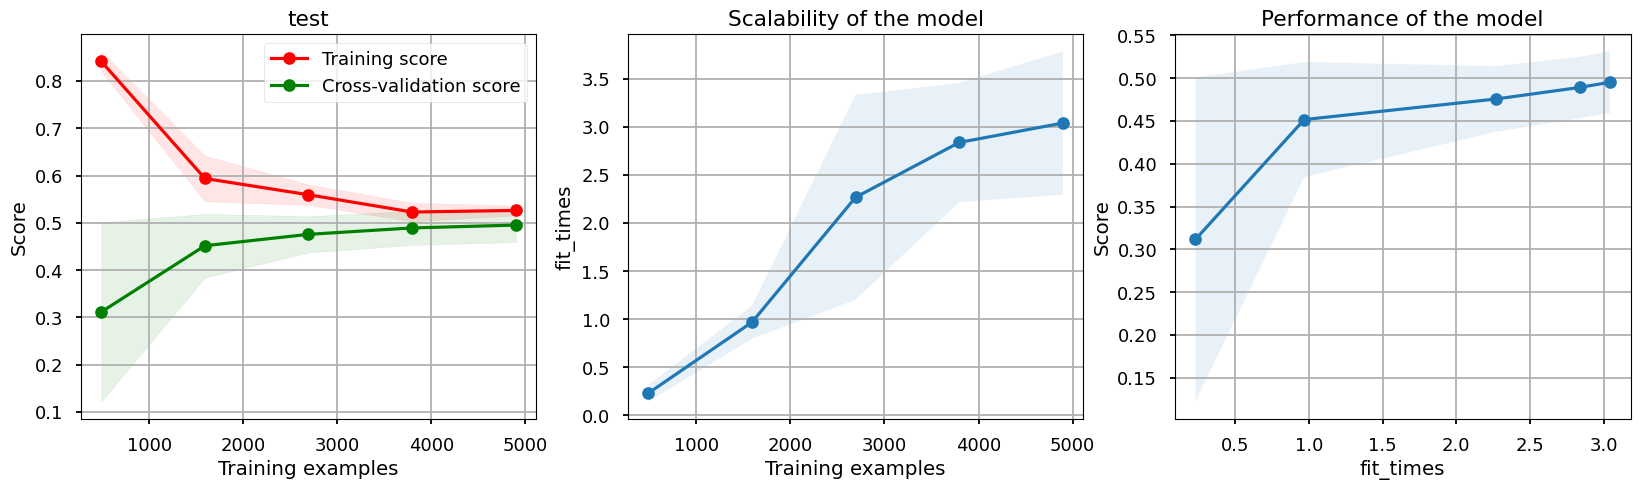

In [32]:
X, y = data['test'][0], data['test'][1]

title = "Learning Curves (Naive Bayes)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

plc.plot_learning_curve(log_reg, 'test', X, y)
# plc.plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()


In [ ]:

# Fit and score the logistic regression
clf_pipe.fit(*data['train'])
train_y_pred = clf_pipe.predict(data['train'][0])
valid_y_pred = clf_pipe.predict(data['valid'][0])
test_y_pred = clf_pipe.predict(data['test'][0])

train_bal_acc = balanced_accuracy_score(data['train'][1], train_y_pred)
valid_bal_acc = balanced_accuracy_score(data['valid'][1], valid_y_pred)
test_bal_acc = balanced_accuracy_score(data['test'][1], test_y_pred)

print('Sleep staging performance with logistic regression:')
print(f'Train bal acc: {train_bal_acc:0.4f}')
print(f'Valid bal acc: {valid_bal_acc:0.4f}')
print(f'Test bal acc: {test_bal_acc:0.4f}')

print('Results on test set:')
print(confusion_matrix(data['test'][1], test_y_pred))
print(classification_report(data['test'][1], test_y_pred))

The balanced accuracy is much higher than chance-level (i.e., 20% for our
5-class classification problem). Finally, we perform a quick 2D visualization
of the feature space using a PCA:




In [72]:
X = np.concatenate([v[0] for k, v in data.items()])
y = np.concatenate([v[1] for k, v in data.items()])

:: plotting UMAP... 

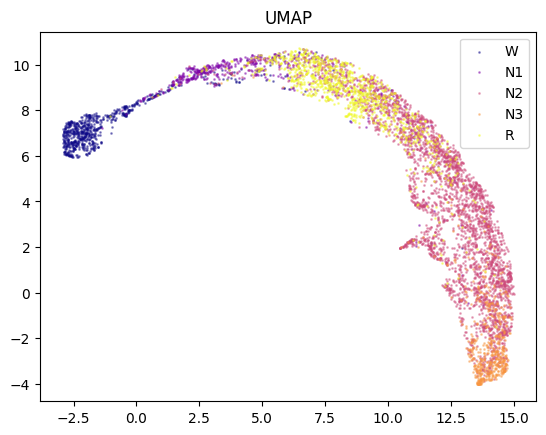

Done


In [74]:
annotations = ['W', 'N1', 'N2', 'N3', 'R']

print(':: plotting UMAP... ', end='')
_umap = umap.UMAP(n_neighbors=15)
umap_components = _umap.fit_transform(X)

n_stages = len(annotations)

fig, ax = plt.subplots()
colors = cm.get_cmap('plasma', n_stages)(range(n_stages))
for i, stage in enumerate(annotations):
    mask = y == i
    ax.scatter(umap_components[mask, 0], umap_components[mask, 1], s=1, alpha=0.4,
    color=colors[i], label=stage)
ax.legend()

ax.set_title('UMAP')
plt.show()

print('Done')

In [83]:
mask = y == i
mask.shape, mask

((6121,), array([False, False, False, ..., False, False, False]))

In [84]:
X.shape

(6121, 100)

In [126]:
clean_X, clean_y = [], []
for k,v in enumerate(X):
    if y[k] == 0:
        clean_X += [v]
        clean_y += [y[k]]

clean_X, clean_y = np.array(clean_X), np.array(clean_y)

In [128]:
X

array([[-0.5433375 ,  0.5655699 , -0.66367704, ...,  0.92807865,
         1.0312976 , -0.7660415 ],
       [-0.87123024,  0.602346  , -0.28879988, ...,  0.64443046,
         0.79656005, -0.97435486],
       [-0.47733092,  0.93945134, -0.16761595, ...,  0.64998084,
         0.89837265, -0.8662975 ],
       ...,
       [-0.9486403 ,  1.9144969 , -0.5434335 , ...,  0.28992456,
         0.39427787, -0.7969985 ],
       [-1.096101  ,  1.660558  , -0.8661281 , ...,  0.29753765,
         1.3744303 , -0.6591681 ],
       [-1.115109  ,  1.6880977 , -0.86111903, ...,  0.31105936,
         1.355728  , -0.632229  ]], dtype=float32)

In [127]:
clean_X

array([[-0.5433375 ,  0.5655699 , -0.66367704, ...,  0.92807865,
         1.0312976 , -0.7660415 ],
       [-0.87123024,  0.602346  , -0.28879988, ...,  0.64443046,
         0.79656005, -0.97435486],
       [-0.47733092,  0.93945134, -0.16761595, ...,  0.64998084,
         0.89837265, -0.8662975 ],
       ...,
       [-0.9486403 ,  1.9144969 , -0.5434335 , ...,  0.28992456,
         0.39427787, -0.7969985 ],
       [-1.096101  ,  1.660558  , -0.8661281 , ...,  0.29753765,
         1.3744303 , -0.6591681 ],
       [-1.115109  ,  1.6880977 , -0.86111903, ...,  0.31105936,
         1.355728  , -0.632229  ]], dtype=float32)

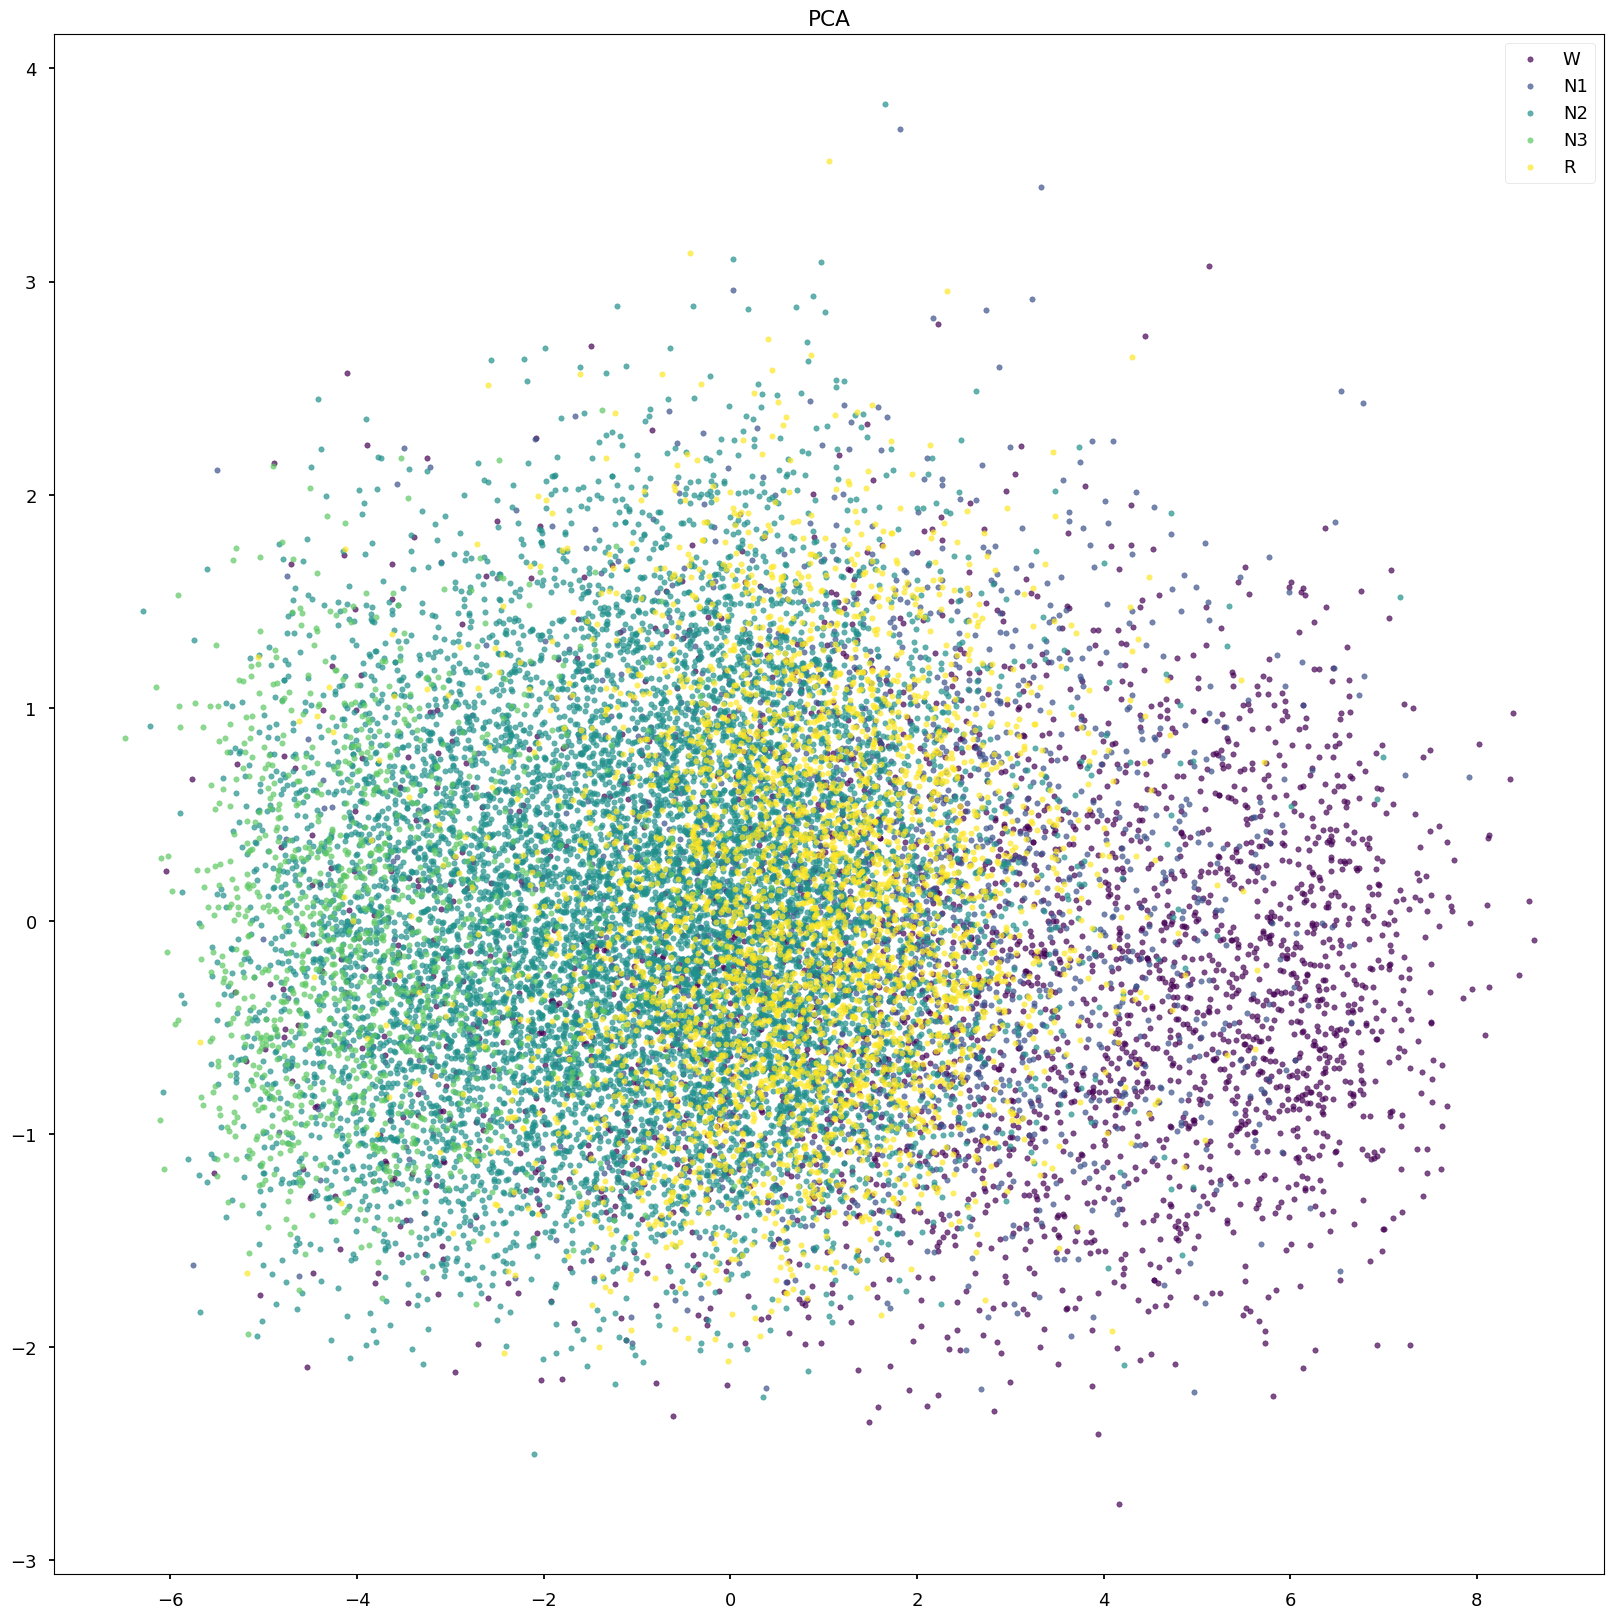

In [56]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

components = [
    pca_components
]
components_titles = [
    'PCA'
]

fig, ax = plt.subplots(1, figsize=(20,20))
colors = cm.get_cmap('viridis', 5)(range(5))
for i, stage in enumerate(['W', 'N1', 'N2', 'N3', 'R']):
    mask = y == i
    ax.scatter(pca_components[mask, 0], pca_components[mask, 1], s=15, alpha=0.7,
            color=colors[i], label=stage)
ax.legend()

ax.set_title(components_titles[0])


plt.show()

In [91]:
d = {k:v for k,v in enumerate(mapping)}

series['labels'] = series['annots'].map(map)

In [96]:
mapping = ['W', 'N1', 'N2', 'N3', 'R']
map = {k:v for k,v in enumerate(mapping)}

print(':: plotting 3D UMAP... ', end='')
umap_3d = UMAP(n_components=3, init='random', random_state=0)
proj_3d = umap_3d.fit_transform(X)
# if annotating feature space with descriptions instead
# if len(descriptions) > 0:
#     annotations = mapping
#     y = descriptions
series = pd.DataFrame(y, columns=['annots'])
series['labels'] = series['annots'].map(map)

fig_3d = px.scatter_3d(
    proj_3d,
    x=0, y=1, z=2,
    color=series.annots,
    labels={'color': 'labels'}
)

fig_3d.update_layout(
    autosize=False,
    width=850,
    height=850
)
fig_3d.update_traces(showlegend=True, marker_size=3)

fig_3d.show()

:: plotting 3D UMAP... 

In [97]:
series

annots labels
0          0      W
1          0      W
2          0      W
3          0      W
4          0      W
...      ...    ...
6116       0      W
6117       0      W
6118       0      W
6119       0      W
6120       0      W

[6121 rows x 2 columns]

We see that there is sleep stage-related structure in the embedding. A
nonlinear projection method (e.g., tSNE, UMAP) might yield more insightful
visualizations. Using a similar approach, the embedding space could also be
explored with respect to subject-level features, e.g., age and sex.




In [62]:
import sys
import importlib

importlib.reload(sys.modules['plot'])
from plot import Plot

p.plot_UMAP_3d(X, y)


AttributeError: module 'matplotlib.pyplot' has no attribute 'write_html'

In [51]:
umap_3d = UMAP(n_components=3, init='random', random_state=0)
proj_3d = umap_3d.fit_transform(X)
series = pd.DataFrame(y, columns=['annots'])

fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=series.annots, labels={'color': 'annots'}
)

fig_3d.update_layout(
    autosize=False,
    width=850,
    height=850
)
fig_3d.update_traces(marker_size=3)


In [53]:
X = np.concatenate([v[0] for k, v in data.items()])
y = np.concatenate([v[1] for k, v in data.items()])

# combine all vectors (X) and labels (y) from RAW_DATA sets
X_raw = np.concatenate([v[0] for k, v in raw_data.items()])
y_raw = np.concatenate([v[1] for k, v in raw_data.items()])

In [59]:
len(X[0])

100

In [75]:
# plt.ylim(0, 1)
        
print(':: plotting learning curves (sklearn)... ', end='')
_, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.rc('font', size=26)
plt.rc('xtick', labelsize=26) 
plt.rc('ytick', labelsize=26)
plt.rc('axes', labelsize=26)
ax.grid()
ax.set_xlabel("Training examples")
ax.set_ylabel('balanced_accuracy')

plt.title(f'Learning curves of balanced accuracy per training example for TEST dataset', fontsize=28)
plt.plot(X[0], X[1], '-', color='r', label='SSL')
# plt.plot(X[0], y, '-', color='g', label='FS')
plt.legend(loc="best")

plt.savefig('test.pdf')

print('Done')

:: plotting learning curves (sklearn)... Done


In [69]:
import matplotlib.pyplot as plt

figure = fig_3d
print(figure)

Figure({
    'data': [{'hovertemplate': '0=%{x}<br>1=%{y}<br>2=%{z}<br>annots=%{marker.color}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': array([0, 0, 0, ..., 0, 0, 0]), 'coloraxis': 'coloraxis', 'size': 3, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'scene': 'scene',
              'showlegend': False,
              'type': 'scatter3d',
              'x': array([4.3477497, 2.298548 , 4.11556  , ..., 5.1744156, 5.319735 , 5.189797 ],
                         dtype=float32),
              'y': array([3.4693089, 2.5058055, 2.6599278, ..., 1.9345498, 2.5062177, 2.43063  ],
                         dtype=float32),
              'z': array([3.822287 , 5.4236007, 4.9881253, ..., 5.047424 , 4.764585 , 4.7081037],
                         dtype=float32)}],
    'layout': {'autosize': False,
               'coloraxis': {'colorbar': {'title': {'text': 'annots'}},
                             'colorscale': [[0

In [71]:
dt = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
# show fig
# plt.show()
figure.write_html(f'plots/{dt}.test_umap_3d.html')

## Conclusion




In this example, we used self-supervised learning (SSL) as a way to learn
representations from unlabelled raw EEG data. Specifically, we used the
relative positioning (RP) pretext task to train a feature extractor on a
subset of the Sleep Physionet dataset. We then reused these features in a
downstream sleep staging task. We achieved reasonable downstream performance
and further showed with a 2D projection that the learned embedding space
contained sleep-related structure.

Many avenues could be taken to improve on these results. For instance, using
the entire Sleep Physionet dataset or training on larger datasets should help
the feature extractor learn better representations during the pretext task.
Other SSL tasks such as those described in [1]_ could further help discover
more powerful features.


## References

.. [1] Banville, H., Chehab, O., Hyvärinen, A., Engemann, D. A., & Gramfort, A.
      (2020). Uncovering the structure of clinical EEG signals with
      self-supervised learning. arXiv preprint arXiv:2007.16104.

.. [2] Kemp, B., Zwinderman, A. H., Tuk, B., Kamphuisen, H. A., & Oberye, J. J.
       (2000). Analysis of a sleep-dependent neuronal feedback loop: the
       slow-wave microcontinuity of the EEG. IEEE Transactions on Biomedical
       Engineering, 47(9), 1185-1194.

.. [3] Goldberger, A. L., Amaral, L. A., Glass, L., Hausdorff, J. M., Ivanov,
       P. C., Mark, R. G., ... & Stanley, H. E. (2000). PhysioBank,
       PhysioToolkit, and PhysioNet: components of a new research resource for
       complex physiologic signals. circulation, 101(23), e215-e220.

.. [4] Chambon, S., Galtier, M., Arnal, P., Wainrib, G. and Gramfort, A.
      (2018)A Deep Learning Architecture for Temporal Sleep Stage
      Classification Using Multivariate and Multimodal Time Series.
      IEEE Trans. on Neural Systems and Rehabilitation Engineering 26:
      (758-769)




# Applying alternative dataset to model

In [ ]:
tuhab_sample_1_path = "/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/braindecode_ssl_thesis/data/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v2.0.0/edf/eval/abnormal/01_tcp_ar/007/00000768/s003_2012_04_06/00000768_s003_t000.edf"
# tuhab_sample_2_path = "/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/braindecode_ssl_thesis/data/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v2.0.0/edf/eval/abnormal/01_tcp_ar/011/00001154/s007_2012_07_25/00001154_s007_t000.edf"
tuhab_sample_2_path = "/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/braindecode_ssl_thesis/data/isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_abnormal/v2.0.0/edf/eval/abnormal/01_tcp_ar/012/00001217/00001217_s002_t000.edf"

sample_1 = mne.io.read_raw_edf(tuhab_sample_1_path, preload=True, stim_channel='auto')
sample_2 = mne.io.read_raw_edf(tuhab_sample_2_path, preload=True, stim_channel='auto')


In [ ]:
# samples = [sample_1]

In [ ]:
# samples = create_from_mne_raw(
#     samples,
#     trial_start_offset_samples=0,
#     trial_stop_offset_samples=0,
#     window_size_samples=500,
#     window_stride_samples=500,
#     drop_last_window=True,
#     # descriptions=descriptions,
# )

In [ ]:
# sample = mne.io.RawArray(sample_1, info=mne.create_info(sample_1.ch_names, sfreq=250))

In [ ]:
# for sample in samples:
#     mne.io.Raw.filter(sample, l_freq=None,h_freq=30, n_jobs=1)

In [ ]:
# print(f'{len(temp)}\t\t {len(temp_raw)}')
# temp.datasets[0]

# samples.datasets = [sample_1, sample_2]

In [13]:
# # 5, 6, 7, 10, 13, 14 are codes for executed and imagined hands/feet

# subject_id = 22
# event_codes = [
#     1, 2, # eyes open, eyes closed
#     # 3, 4, 5, 6, 7, 8, 9, 
#     # 10, 11, 12, 13, 14
# ]

# # This will download the files if you don't have them yet,
# # and then return the paths to the files.
# physionet_paths = mne.datasets.eegbci.load_data(
#     subject_id, event_codes, update_path=False)

# # Load each of the files
# eegmmidb = [mne.io.read_raw_edf(path, preload=True, stim_channel='auto')
#          for path in physionet_paths]

In [5]:
''' ANNOTATIONS
T0 corresponds to rest
T1 corresponds to onset of motion (real or imagined) of
    the left fist (in runs 3, 4, 7, 8, 11, and 12)
    both fists (in runs 5, 6, 9, 10, 13, and 14)
T2 corresponds to onset of motion (real or imagined) of
    the right fist (in runs 3, 4, 7, 8, 11, and 12)
    both feet (in runs 5, 6, 9, 10, 13, and 14)
'''

subjects = range(1,6)
event_codes = [
    1, 2, # eyes open, eyes closed
    3, 4, 5,
    6, 7, 8, 9, 
    10, 11, 12, 13, 14
]

physionet_paths, descriptions = [], []

for subject_id in subjects:
    physionet_paths += [mne.datasets.eegbci.load_data(subject_id, event_codes, update_path=False)]
    descriptions += [{"event_code": code, "subject": subject_id} for code in event_codes]

# flatten list of paths
physionet_paths = [x for sublist in physionet_paths for x in sublist]

# exclude channels which are not in Sleep Staging dataset
# exclude = list(x for x in eegmmidb[0].ch_names if x not in ['Fpz.', 'Pz..'])
exclude = [
    'Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..',
    'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.',
    'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fp2.', 'Af7.', 
    'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 
    'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 
    'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 
    'P1..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 
    'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']

# Load each of the files
eegmmidb = [mne.io.read_raw_edf(path, preload=True, stim_channel='auto', exclude=exclude) for path in physionet_paths]

Extracting EDF parameters from /home/maligan/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /home/maligan/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /home/maligan/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/maligan/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ex

Extracting EDF parameters from /home/maligan/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/maligan/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/maligan/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/maligan/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Extracting EDF parameters from /home/maligan/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/maligan/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/maligan/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/maligan/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


In [6]:
# # Select the same channels as sleep staging model

# import copy

# _eegmmidb = copy.deepcopy(eegmmidb)
# _eegmmidb[0].ch_names

# for i, channel in enumerate(eegmmidb):
#     for x in channel.ch_names:
#         if x not in ['Fpz.', 'Pz..']:
#             _eegmmidb[i].drop_channels(x)

# _eegmmidb[0].ch_names

In [7]:
### preprocess
# resample to 100Hz
# high pass filtering of 30Hz

sfreq = 160 # original
high_cut_hz = 30
n_jobs = 1

for channel in eegmmidb:
    # mne.io.Raw.resample(channel, sfreq)   # resample
    mne.io.Raw.filter(channel, l_freq=None, h_freq=high_cut_hz, n_jobs=n_jobs)    # high-pass filter


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 71 samples (0.444 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 71 samples (0.444 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter par

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 71 samples (0.444 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 71 samples (0.444 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a o

---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 71 samples (0.444 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 71 samples (0.444 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed 

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 71 samples (0.444 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 71 samples (0.444 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and

In [8]:
window_size_samples = 500

mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Eyes closed': 0,
    'Eyes open': 1,
}

eegmmidb_windows = create_from_mne_raw(
    eegmmidb,
    trial_start_offset_samples=0,
    trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples,
    drop_last_window=True,
    descriptions=descriptions,
    # mapping=mapping,
    # preload=True
)

Used Annotations descriptions: ['T0']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
19 matching events found
No baseline correction applied
0 projection items activated
Loading data for 19 events and 500 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['T0']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
19 matching events found
No baseline correction applied
0 projection items activated
Loading data for 19 events and 500 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['T0', 'T1', 'T2']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
30 matching events found
No baseline correction applied
0 projection items activated
Loading data for 30 events and 500 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['T0', 'T1', 'T2']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
30 matching events found
No ba

No baseline correction applied
0 projection items activated
Loading data for 19 events and 500 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['T0']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
19 matching events found
No baseline correction applied
0 projection items activated
Loading data for 19 events and 500 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['T0', 'T1', 'T2']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
30 matching events found
No baseline correction applied
0 projection items activated
Loading data for 30 events and 500 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['T0', 'T1', 'T2']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
30 matching events found
No baseline correction applied
0 projection items activated
Loading data for 30 events and 500 original time points ...
0 bad epochs dropped
U

Used Annotations descriptions: ['T0']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
19 matching events found
No baseline correction applied
0 projection items activated
Loading data for 19 events and 500 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['T0', 'T1', 'T2']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
30 matching events found
No baseline correction applied
0 projection items activated
Loading data for 30 events and 500 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['T0', 'T1', 'T2']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
30 matching events found
No baseline correction applied
0 projection items activated
Loading data for 30 events and 500 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['T0', 'T1', 'T2']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
30 matching events

In [9]:
# z-score normalization

from sklearn.preprocessing import scale

'''
Parameters
----------
data: np.ndarray (n_channels, n_times) or (n_windows, n_channels, n_times)
    continuous or windowed signal

Returns
-------
zscored: np.ndarray (n_channels x n_times) or (n_windows x n_channels x n_times)
        normalized continuous or windowed data

..note:
    If this function is supposed to preprocess continuous data, it should be
    given to raw.apply_function().
'''
def zscore(data):
    zscored = data - np.mean(data, keepdims=True, axis=-1)
    zscored = zscored / np.std(zscored, keepdims=True, axis=-1)
    # TODO: the overriding of protected '_data' should be implemented in the
    # TODO: dataset when transforms are applied to windows
    if hasattr(data, '_data'):
        data._data = zscored
    return zscored


In [22]:
# zscore(eegmmidb_windows)
# scale(eegmmidb_windows)
preprocess(eegmmidb_windows, [Preprocessor(zscore)])

Loading data for 19 events and 500 original time points ...
Loading data for 19 events and 500 original time points ...
Loading data for 30 events and 500 original time points ...
Loading data for 30 events and 500 original time points ...
Loading data for 30 events and 500 original time points ...
Loading data for 30 events and 500 original time points ...
Loading data for 30 events and 500 original time points ...
Loading data for 30 events and 500 original time points ...
Loading data for 30 events and 500 original time points ...
Loading data for 30 events and 500 original time points ...
Loading data for 30 events and 500 original time points ...
Loading data for 30 events and 500 original time points ...
Loading data for 30 events and 500 original time points ...
Loading data for 30 events and 500 original time points ...
Loading data for 19 events and 500 original time points ...
Loading data for 19 events and 500 original time points ...
Loading data for 30 events and 500 origi

# Split model and attach new input and output layers

In [10]:
# # --- init vars --- 

# return_feats = False
# input_size = 30
# dropout = 0.25
# n_classes = 2

# # ------------------

# def _len_last_layer(n_channels, input_size):
#     feature_extractor.eval()
#     with torch.no_grad():
#         out = feature_extractor(
#             torch.Tensor(1, 1, n_channels, input_size))
#     feature_extractor.train()
#     print(len(out.flatten()))
#     return len(out.flatten())


# # INPUT
# # if multichannel, add spatial conv
# n_channels = len(_eegmmidb[0].ch_names)
# if n_channels > 1:
#     spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

# # FEATURE EXTRACTOR - pretrained model
# feature_extractor = clf.module_.emb.feature_extractor

# # OUTPUT
# len_last_layer = _len_last_layer(n_channels, input_size)
# # if not return_feats:
# fc = nn.Sequential(
#     nn.Dropout(dropout),
#     nn.Linear(len_last_layer, n_classes)
# )

## Fine tune on Sleep staging SSL model

In [11]:
# split by subject

# subjects = np.unique(windows_dataset.description['subject'])
# subj_train, subj_test = train_test_split(
#     subjects, test_size=0.4, random_state=random_state)
# subj_valid, subj_test = train_test_split(
#     subj_test, test_size=0.5, random_state=random_state)


# bci dataset
subjects = np.unique(eegmmidb_windows.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)




class RelativePositioningDataset(BaseConcatDataset):
    """BaseConcatDataset with __getitem__ that expects 2 indices and a target.
    """
    def __init__(self, list_of_ds):
        super().__init__(list_of_ds)
        self.return_pair = True

    def __getitem__(self, index):
        if self.return_pair:
            ind1, ind2, y = index
            return (super().__getitem__(ind1)[0],
                    super().__getitem__(ind2)[0]), y
        else:
            return super().__getitem__(index)

    @property
    def return_pair(self):
        return self._return_pair

    @return_pair.setter
    def return_pair(self, value):
        self._return_pair = value


# split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
# splitted = dict()
# for name, values in split_ids.items():
#     splitted[name] = RelativePositioningDataset(
#         [ds for ds in windows_dataset.datasets
#             if ds.description['subject'] in values])

split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = RelativePositioningDataset(
        [ds for ds in eegmmidb_windows.datasets
            if ds.description['subject'] in values])

# test_ds = RelativePositioningDataset([ds for ds in eegmmidb_windows.datasets])

In [12]:
# splitted['test'].datasets[0][0][0] == splitted['test'][0]
# test_ds.datasets[0][0][0]

# test_ds_data

In [13]:
tau_pos, tau_neg = int(sfreq * 60), int(sfreq * 15 * 60)
n_examples_train = 250 * len(splitted['train'].datasets)
n_examples_valid = 250 * len(splitted['valid'].datasets)
n_examples_test = 250 * len(splitted['test'].datasets)

# n_examples_test = 250 * len(test_ds.datasets)

train_sampler = RelativePositioningSampler(
    splitted['train'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_train, same_rec_neg=True, random_state=random_state)
valid_sampler = RelativePositioningSampler(
    splitted['valid'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_valid, same_rec_neg=True,
    random_state=random_state)
test_sampler = RelativePositioningSampler(
    splitted['test'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_test, same_rec_neg=True,
    random_state=random_state)

In [14]:
###############################
# trying w/o sequential layer #
###############################

model.emb.return_feats = False

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to reproduce results
set_random_seeds(seed=random_state, cuda=device == 'cuda')

batch_size = 512
num_workers = 1

# Extract features with the trained embedder
data = dict()
for name, split in splitted.items():
    split.return_pair = False  # Return single windows
    loader = DataLoader(split, batch_size=batch_size, num_workers=num_workers)
    with torch.no_grad():
        feats = [model.emb(batch_x.to(device)).cpu().numpy()
                    for batch_x, _, _ in loader]
    data[name] = (np.concatenate(feats), split.get_metadata()['target'].values)

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points ...
Loading data for 1 events and 500 original time points .

In [16]:
# Extract features with the trained embedder (TEST DATASET)
# for name, split in splitted.items():

# test_ds.return_pair = False  # Return single windows
# loader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)
# with torch.no_grad():
#     feats = [emb(batch_x.to(device)).cpu().numpy()
#                 for batch_x, _, _ in loader]
# test_ds_data = (np.concatenate(feats), test_ds.get_metadata()['target'].values)

In [16]:
# Initialize the logistic regression model
log_reg = LogisticRegression(
    penalty='l2', C=1.0, class_weight='balanced', solver='sag',
    multi_class='multinomial', random_state=random_state)
clf_pipe = make_pipeline(StandardScaler(), log_reg)

# Fit the logistic regression
clf_pipe.fit(*data['train'])

/home/maligan/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced',
                                    multi_class='multinomial', random_state=87,
                                    solver='sag'))])

In [17]:
# score logistic regression
train_y_pred = clf_pipe.predict(data['train'][0])
valid_y_pred = clf_pipe.predict(data['valid'][0])
test_y_pred = clf_pipe.predict(data['test'][0])
# test_ds_y_pred = clf_pipe.predict(test_ds_data[0])

train_bal_acc = balanced_accuracy_score(data['train'][1], train_y_pred)
valid_bal_acc = balanced_accuracy_score(data['valid'][1], valid_y_pred)
test_bal_acc = balanced_accuracy_score(data['test'][1], test_y_pred)
# test_ds_acc = balanced_accuracy_score(test_ds_data[1], test_ds_y_pred)

print('Sleep staging performance with logistic regression:')
print(f'Train bal acc: {train_bal_acc:0.4f}')
print(f'Valid bal acc: {valid_bal_acc:0.4f}')
print(f'Test bal acc: {test_bal_acc:0.4f}')
# print(f'Test bal acc: {test_ds_acc:0.4f}')

print('Results on test set:')
print(confusion_matrix(data['test'][1], test_y_pred))
print(classification_report(data['test'][1], test_y_pred))

Sleep staging performance with logistic regression:
Train bal acc: 0.5713
Valid bal acc: 0.3977
Test bal acc: 0.4636
Results on test set:
[[ 44 115  59]
 [  5  60  25]
 [ 10  33  47]]
              precision    recall  f1-score   support

           0       0.75      0.20      0.32       218
           1       0.29      0.67      0.40        90
           2       0.36      0.52      0.43        90

    accuracy                           0.38       398
   macro avg       0.46      0.46      0.38       398
weighted avg       0.55      0.38      0.36       398



In [19]:
with open('clf_pipe.pkl', 'wb+') as f:
    pickle.dump(clf_pipe, f)
f.close()

In [28]:
with open('clf_pipe.pkl', 'rb') as f:
    clf_pipe_loaded = pickle.load(f)
f.close()

In [18]:
X = np.concatenate([v[0] for k, v in data.items()])
y = np.concatenate([v[1] for k, v in data.items()])

In [20]:
p = Plot('test')

In [24]:
import sys
import importlib

importlib.reload(sys.modules['plot'])
from plot import Plot

p = Plot('test')

p.plot_UMAP_3d(X, y)

:: plotting 3D UMAP...
:: 3d UMAP saved


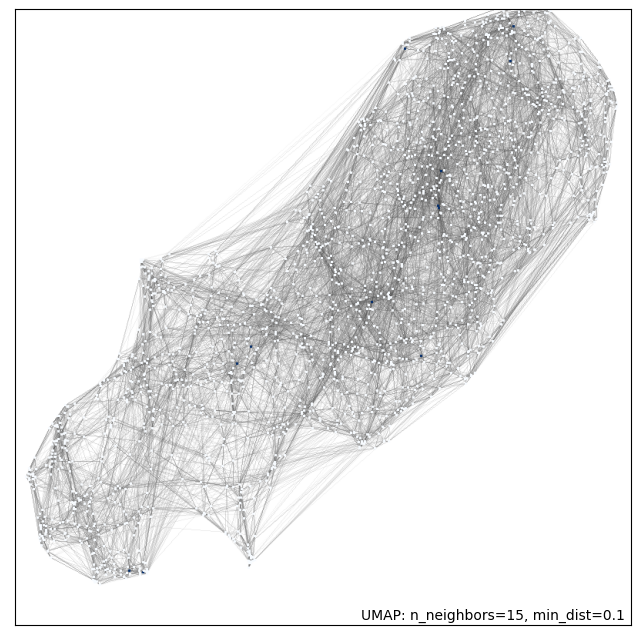

In [34]:
mapping = UMAP(n_components=2, init='spectral').fit(X)

umap.plot.connectivity(mapping, show_points=True)
# umap.plot.connectivity(mapping, edge_bundling='hammer') # bundles edges

plt.show()


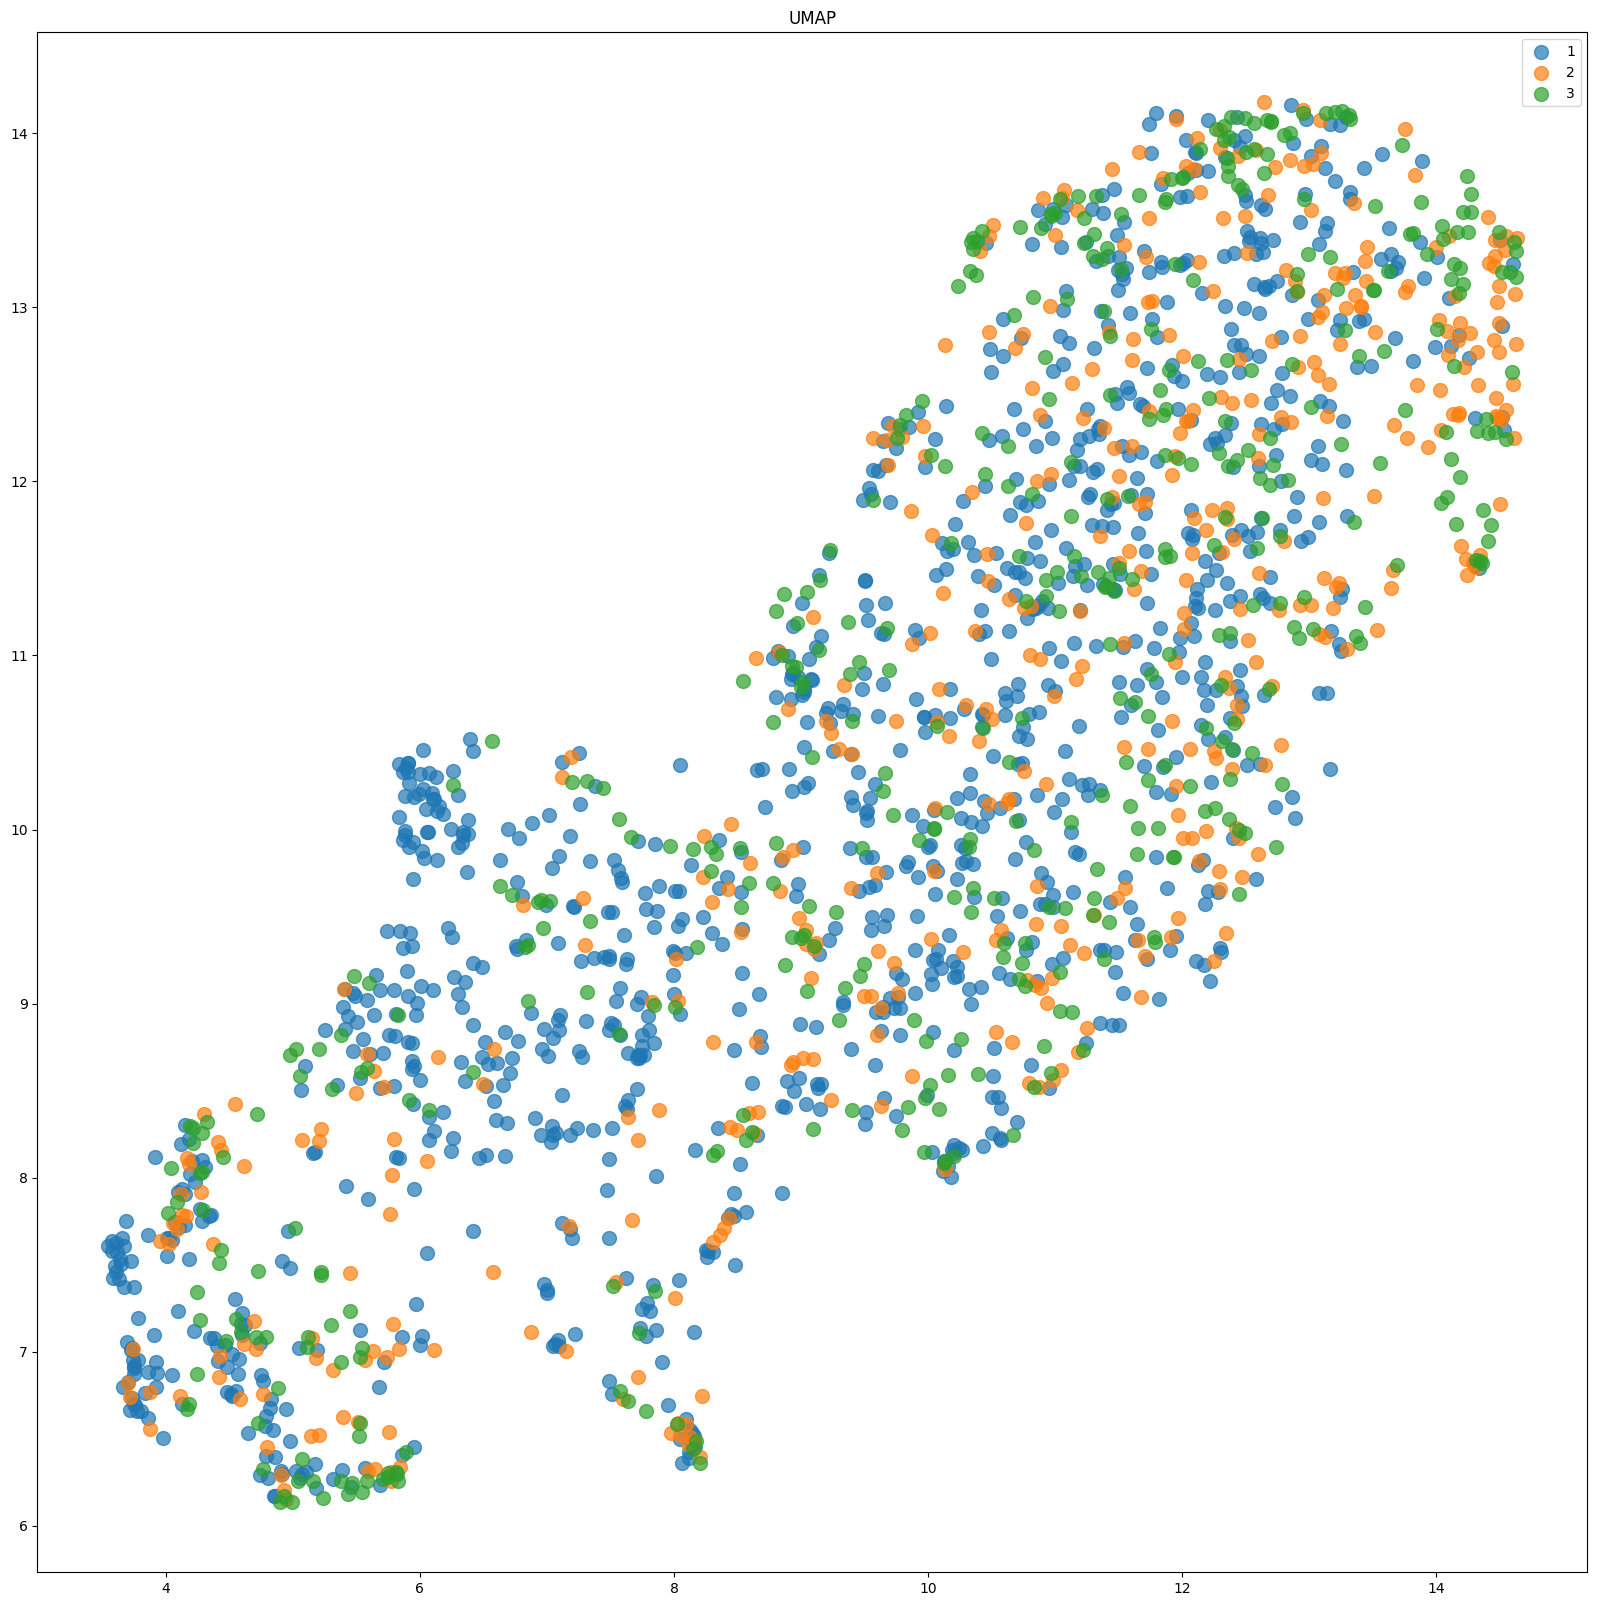

In [17]:
_umap = umap.UMAP(n_neighbors=15)

umap_components = _umap.fit_transform(X)

components = [
    # pca_components,
    # tsne_components,
    umap_components
]
components_titles = [
    'UMAP'
 ]

# SINGLE plot
fig, ax = plt.subplots(1, figsize=(20,20))
colors = cm.get_cmap('viridis', 5)(range(5))
for i, stage in enumerate(['1', '2', '3']):
    mask = y == i
    ax.scatter(umap_components[mask, 0], umap_components[mask, 1], s=100, alpha=0.7, label=stage)
ax.legend()

ax.set_title(components_titles[0])

plt.show()


In [132]:
X = np.concatenate([v[0] for k, v in data.items()])
y = np.concatenate([v[1] for k, v in data.items()])

pca = PCA(n_components=2)
tsne = TSNE(n_components=2)
_umap = umap.UMAP(n_neighbors=15)

pca_components = pca.fit_transform(X)
tsne_components = tsne.fit_transform(X)
umap_components = _umap.fit_transform(X)

components = [
    pca_components,
    tsne_components,
    umap_components
]
components_titles = [
    'PCA',
    'TSNE',
    'UMAP'
 ]

# SINGLE plot
# fig, ax = plt.subplots(1, figsize=(20,20))
# colors = cm.get_cmap('viridis', 5)(range(5))
# for i, stage in enumerate(['W', 'N1', 'N2', 'N3', 'R']):
#     mask = y == i
#     ax.scatter(umap_components[mask, 0], umap_components[mask, 1], s=10, alpha=0.7,
#             color=colors[i], label=stage)
# ax.legend()

# ax.set_title(components_titles[0])

# MULTI plot
fig, ax = plt.subplots(3, figsize=(15,30))
for component_i, component_plot in enumerate(components):
    colors = cm.get_cmap('viridis', 5)(range(5))
    for i, stage in enumerate(['T0', 'T1', 'T2']):
        mask = y == i
        ax[component_i].scatter(component_plot[mask, 0], component_plot[mask, 1], s=10, alpha=0.7,
                color=colors[i], label=stage)
    ax[component_i].legend()
    
    ax[component_i].set_title(components_titles[component_i])

plt.show()

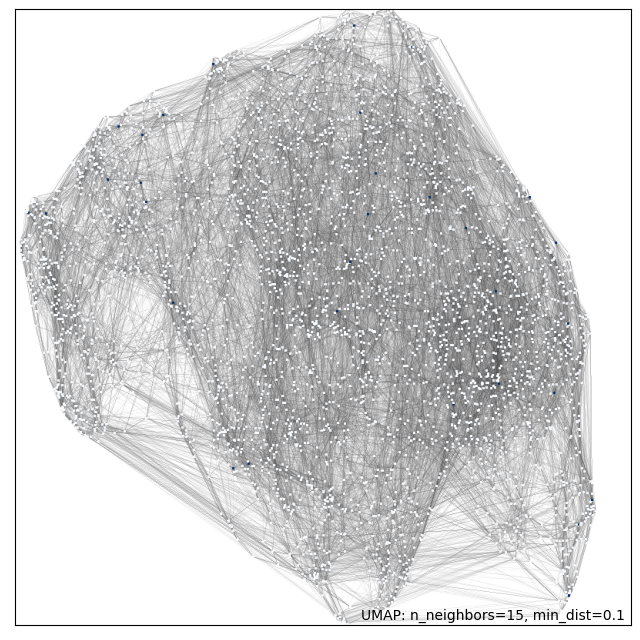

In [ ]:
# UMAP plot with connectivity
# https://umap-learn.readthedocs.io/en/latest/plotting.html


mapping = _umap.fit(X)

fig = umap.plot.connectivity(mapping, show_points=True)
# umap.plot.connectivity(mapping, edge_bundling='hammer') # decreased connectivity (more readable (prettier))

plt.show()

In [29]:
# 3D UMAP plot

umap_3d = UMAP(n_components=3, init='random', random_state=0)
proj_3d = umap_3d.fit_transform(X)
series = pd.DataFrame(y, columns=['annots'])

fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=series.annots, labels={'color': 'annots'}
)

fig_3d.update_layout(
    autosize=False,
    width=850,
    height=850,
    # margin=dict(
    #     l=50,
    #     r=50,
    #     b=100,
    #     t=100,
    #     pad=4
    # ),
)
fig_3d.update_traces(marker_size=3)

fig_3d.show()

In [ ]:
# df = pd.DataFrame(data['test'][0][0])

# with open('bci_vectors.tsv', 'wb+') as f:
    # f.write(X)

np.savetxt('bci_vectors.tsv', X, delimiter='\n')

# to_csv('bci_vectors.tsv', sep='\t')

In [ ]:
### convert to csv for Robin's Viewer

import pandas as pd

# add time column
time = [x/100 for x in range(len(y))]
_y = np.expand_dims(y, 0)
_y = np.insert(_y, 0, time, axis=0)

df = pd.DataFrame(_y.T, columns=["Time", "model"]).set_index('Time')
df.to_csv("predictions_output.csv")

df

### LOADING TUAR

In [2]:
sfreq = 100
low_cut_hz = 0.5
high_cut_hz = 30
n_jobs = 1
window_size_samples = 500

In [7]:
import pprint
p = pprint.PrettyPrinter(indent=2)

In [4]:
print(':: loading TUAR data')

# data_dir = 'data/tuar/v2.1.0/edf/01_tcp_ar/'
data_dir = '/media/maligan/My Passport/msc_thesis/data/tuar/v2.1.0/edf/01_tcp_ar/'

# build data dictionary
subjects = {}
for subject in hf.get_file_list(data_dir):
    recordings = {}
    for recording in hf.get_file_list(subject):
        dates = {}
        for date in hf.get_file_list(recording):
            for raw_path in hf.get_file_list(date):
                if '_2_channels.fif' in hf.get_id(raw_path):
                    break
                else:
                    pass
            dates[hf.get_id(date)] = raw_path
        recordings[hf.get_id(recording)] = dates
    subjects[hf.get_id(subject)] = recordings


df = pd.json_normalize(subjects, sep='_').T

# paths list
raw_paths = [df.iloc[i][0] for i in range(len(df))]

:: loading TUAR data


In [12]:
dir = "/media/maligan/My Passport/msc_thesis/data/tuar/v2.1.0/edf/01_tcp_ar/002/00000254/s005_2010_11_15/00000254_s005_t000.edf"
raw = mne.io.read_raw_edf(dir)
raw

Extracting EDF parameters from /media/maligan/My Passport/msc_thesis/data/tuar/v2.1.0/edf/01_tcp_ar/002/00000254/s005_2010_11_15/00000254_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<RawEDF | 00000254_s005_t000.edf, 36 x 360500 (1442.0 s), ~39 kB, data not loaded>

In [17]:
raw.ch_names

['EEG FP1-REF',
 'EEG FP2-REF',
 'EEG F3-REF',
 'EEG F4-REF',
 'EEG C3-REF',
 'EEG C4-REF',
 'EEG P3-REF',
 'EEG P4-REF',
 'EEG O1-REF',
 'EEG O2-REF',
 'EEG F7-REF',
 'EEG F8-REF',
 'EEG T3-REF',
 'EEG T4-REF',
 'EEG T5-REF',
 'EEG T6-REF',
 'EEG A1-REF',
 'EEG A2-REF',
 'EEG FZ-REF',
 'EEG CZ-REF',
 'EEG PZ-REF',
 'EEG ROC-REF',
 'EEG LOC-REF',
 'EEG EKG1-REF',
 'EMG-REF',
 'EEG 26-REF',
 'EEG 27-REF',
 'EEG 28-REF',
 'EEG 29-REF',
 'EEG 30-REF',
 'EEG T1-REF',
 'EEG T2-REF',
 'PHOTIC-REF',
 'IBI',
 'BURSTS',
 'SUPPR']

In [25]:
ch = mne.pick_channels(raw.info['ch_names'], include=['EEG FP1-REF', 'EEG FP2-REF'])
ch_dict = dict(fpz_1=ch)

In [28]:
x = mne.channels.combine_channels(raw, ch_dict, method='mean')

Creating RawArray with float64 data, n_channels=1, n_times=360500
    Range : 0 ... 360499 =      0.000 ...  1441.996 secs
Ready.


In [31]:
x.ch_names

['fpz_1']

In [8]:
p.pprint(subjects)

{ '002': { '00000254': { 's005_2010_11_15': '/media/maligan/My '
                                            'Passport/msc_thesis/data/tuar/v2.1.0/edf/01_tcp_ar/002/00000254/s005_2010_11_15/00000254_s005_t000.rec_orig',
                         's007_2013_03_25': '/media/maligan/My '
                                            'Passport/msc_thesis/data/tuar/v2.1.0/edf/01_tcp_ar/002/00000254/s007_2013_03_25/00000254_s007_t000.rec_orig'},
           '00000297': { 's004_2012_02_28': '/media/maligan/My '
                                            'Passport/msc_thesis/data/tuar/v2.1.0/edf/01_tcp_ar/002/00000297/s004_2012_02_28/00000297_s004_t000.rec_orig'}},
  '004': { '00000458': { 's004_2003_02_12': '/media/maligan/My '
                                            'Passport/msc_thesis/data/tuar/v2.1.0/edf/01_tcp_ar/004/00000458/s004_2003_02_12/00000458_s004_t001.rec_orig'}},
  '006': { '00000630': { 's002_2003_05_28': '/media/maligan/My '
                                            'Passp

In [3]:
# define descriptions (recoding per subject)
abnormal_descriptions, normal_descriptions, classification = [], [], []
for id in abnormal_subjects:
    for recording in subjects['abnormal'][id].values():
        for x in recording.keys():
            abnormal_descriptions += [{'subject': int(id), 'recording': x}]
            classification += ['abnormal']
for id in normal_subjects:
    for recording in subjects['normal'][id].values():
        for x in recording.keys():
            normal_descriptions += [{'subject': int(id), 'recording': x}]
            classification += ['normal']

descriptions = abnormal_descriptions + normal_descriptions

# shuffle raw_paths and descriptions
from sklearn.utils import shuffle
raw_paths, descriptions, classification = shuffle(raw_paths, descriptions, classification)

# limiters
raw_paths = raw_paths[:50]
descriptions = descriptions[:50]
classification = classification[:50]

# load data and set annotations
dataset = []
for i, path in enumerate(raw_paths):
    _class = classification[i]
    raw = mne.io.read_raw_fif(path, preload=True)
    raw = raw.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=[_class]))
    dataset.append(raw)

pp = pprint.PrettyPrinter(indent=2)
pp.pprint(raw_paths)
pp.pprint(dataset)

# preprocess dataset
dataset = preprocess_raws(dataset, sfreq, low_cut_hz, high_cut_hz, n_jobs)

mapping = {
    'abnormal': 0,
    'normal': 1
}

# create windows
windows_dataset = create_windows_dataset(dataset, window_size_samples, descriptions, mapping)

return windows_dataset

:: plotting UMAP with connectivity... 

/home/maligan/.local/lib/python3.8/site-packages/umap/plot.py:885: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


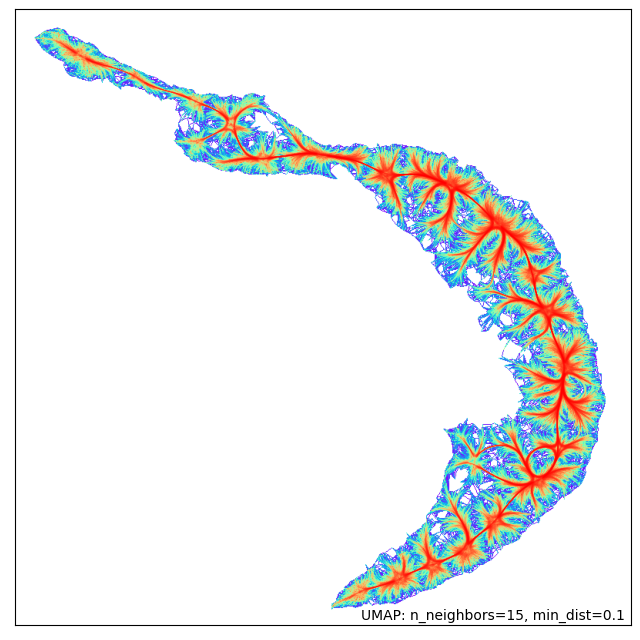

Done


In [25]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
from matplotlib.lines import Line2D
from matplotlib import cm
import seaborn as sns

import umap.plot
import umap.umap_ as UMAP
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from datetime import datetime

from helper_funcs import HelperFuncs as hf

print(':: plotting UMAP with connectivity... ', end='')
title = f'Connectivity UMAP of sleep_staging'
mapping = umap.UMAP(n_components=2, init='random').fit(X)

title += ' (edge bundled)'
umap.plot.connectivity(mapping, edge_bundling='hammer', edge_cmap='rainbow') # bundles edges
    
plt.show()
print('Done')

In [22]:
from plot import Plot

p = Plot(dataset_name='test', metadata_string='test_string')

In [50]:
p.plot_learning_curves_sklearn()

TypeError: plot_learning_curves_sklearn() missing 7 required positional arguments: 'ssl_train_sizes', 'raw_train_sizes', 'ssl_train_scores', 'ssl_test_scores', 'raw_train_scores', 'raw_test_scores', and 'dataset_name'